In [1]:
# !pip list --format=freeze > requirements.txt

# Optiver Realized Volatility Prediction

Le but de ce problème est de prédire la volatilité de "stocks" financiers.

## Description du dataset

Le dataset est constitué de données financières et plus particulièrement de carnets d'ordres et de carnets de transactions effectuées.  
Ces deux "book" sont deux ensembles de fichiers séparés.

Chaque book est classé par stock qui représente un indice financier.  
Pour chaque stock nous avons plusieurs time_id.  
Celles ci font référence à une fenêtre de valeurs réelles de 20 min. Elles ne sont pas chronologiquement consécutives.

Dans chacune de ces fenêtres nous n'avons accès qu'aux premières 10 min de données et nous devons prédire la volatilité dans les 10 min suivantes.  
Nous avons cependant accès à la volatilité réalisée des 10 min suivante.  
Celle ci est donc une valeur unique associée à l'interval de temps et sera notre target.

<img src="./img/DataBucketing.webp" width="300px">  
</br></br>
Example et explication :
</br>
<img src="./img/Data_explainations.png" width="600px">

## Process machine learning

Il s'agit d'un problème de régression supervisé.

Dans un premier temps nous explorerons nos données.  
Puis nous Ferons du feature engineering sur nos dataset de book et trade.

Ensuite il s'agira de agréger nos données sur un seul dataframe avec une ligne par time_id.

<!-- partie sur la validation -->

# Librairies

In [2]:
%matplotlib inline
# generic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

# machine learning
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor


# path and files treatment
import glob
import os

# Variables

In [104]:
# env could be 'local' or 'kaggle'
env = 'local'

if env == 'local':
    data_folder = './data'
    output = './output/'
    if not(os.path.exists(output)):
        os.makedirs(output)

elif env == 'kaggle':
    data_folder = '../input/optiver-realized-volatility-prediction'
    output = './'
else:
    print('env var must be defined')

bk_train_fol = '/book_train.parquet/'
td_train_fol = '/trade_train.parquet/'
bk_test_fol = '/book_test.parquet/'
td_test_fol = '/trade_test.parquet/'

model_final = 'finalized_model.sav'


# Exploration

## Functions

In [4]:
def add_wap(df, number=1, column_prefix='wap'):
    df[column_prefix + str(number)] = (
        df['bid_price'+ str(number)] * df['ask_size'+ str(number)] + df['ask_price'+ str(number)] * df['bid_size'+ str(number)]) / (
            df['bid_size'+ str(number)]+ df['ask_size'+ str(number)])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def load_df(df_folder, nb_stock_to_load=0, data_folder=data_folder):
    '''load a parquet 
    
    arguments
    ---------------
    data_folder (str)
    df_folder (str)
    nb_stock_to_load (int)
        number of subfolders to load
    '''
    stock_list = os.listdir(data_folder + df_folder)

    if nb_stock_to_load == 0:
        nb_stock_to_load = len(stock_list)
    nb_stock_to_load = min(nb_stock_to_load, len(stock_list))
    
    if nb_stock_to_load == 1:
        df = pd.read_parquet(data_folder + df_folder + '/stock_id=0')
        df['stock_id'] = 0
    else:
        ## depreciated
        # subset_paths = []
        # for stock in stock_list[:nb_stock_to_load]:
        #     subset_path = glob.glob(data_folder + df_folder + stock + '/*')
        #     subset_paths.append(subset_path[0])

        subset_paths = [glob.glob(data_folder + df_folder + stock + '/*')[0] for stock in stock_list[:nb_stock_to_load]]
        ## doesn't work
        # subset_paths = glob.glob(data_folder + df_folder + '/*')[:nb_stock_to_load]
        
        df = pd.read_parquet(subset_paths)
        df['stock_id'] = df['stock_id'].astype(int)
    return df

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

## Book train 

In [5]:
book_train = load_df(bk_train_fol, nb_stock_to_load=1)
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [6]:
book_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917553 entries, 0 to 917552
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            917553 non-null  int16  
 1   seconds_in_bucket  917553 non-null  int16  
 2   bid_price1         917553 non-null  float32
 3   ask_price1         917553 non-null  float32
 4   bid_price2         917553 non-null  float32
 5   ask_price2         917553 non-null  float32
 6   bid_size1          917553 non-null  int32  
 7   ask_size1          917553 non-null  int32  
 8   bid_size2          917553 non-null  int32  
 9   ask_size2          917553 non-null  int32  
 10  stock_id           917553 non-null  int64  
dtypes: float32(4), int16(2), int32(4), int64(1)
memory usage: 38.5 MB


### Sample

In [7]:
# Sample
book_train_sample = book_train[(book_train['stock_id'] == 0) & (book_train['time_id'] < 35)].copy()
add_wap(book_train_sample)
fig = px.line(book_train_sample, x="seconds_in_bucket", y="wap1", title='WAP of stock_id_0, time_id <35', color='time_id')
fig.show()

In [8]:
book_train_sample['log_return'] = book_train_sample.groupby(['time_id'])['wap1'].apply(log_return)
book_train_sample = book_train_sample[~book_train_sample['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

In [9]:
fig = px.line(book_train_sample, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id <35', color='time_id')
fig.show()

In [10]:
# Realized volatility on our sample
realized_vol = book_train_sample.groupby(['time_id'])['log_return'].agg(realized_volatility)
print('Realized volatility for stock_id 0 :')
for i in realized_vol.index:
    print(f'- time_id {i} is {round(realized_vol.loc[i], 7)}')

Realized volatility for stock_id 0 :
- time_id 5 is 0.0044994
- time_id 11 is 0.0012044
- time_id 16 is 0.0023685
- time_id 31 is 0.0025738


## Trade train 

In [11]:
# Test tp know if the book and trade data are on same stocks
os.listdir(data_folder + td_train_fol) == os.listdir(data_folder + bk_train_fol)

True

In [12]:
trade_train = load_df(td_train_fol, nb_stock_to_load=2)

In [13]:
trade_train.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


### Sample

In [14]:
trade_train_sample = trade_train[(trade_train.stock_id == 0) & (trade_train.time_id < 35)]

fig = px.line(trade_train_sample, x="seconds_in_bucket", y="price", title='Price of stock_id_0, time_id <35', color='time_id')
fig.show()

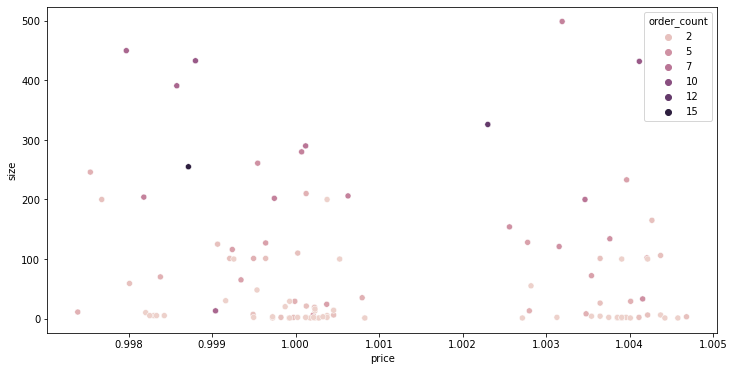

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=trade_train_sample, x="price", y="size", hue="order_count")

plt.show()

## Book/Trade test

These file are here just to show the shape and firsts value of the hidden 10 min window.

In [16]:
book_test = load_df(bk_test_fol)
book_test.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24,0
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20,0
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15,0


In [17]:
trade_test = load_df(td_test_fol)
trade_test.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,4,7,1.000344,1,1,0
1,4,24,1.000049,100,7,0
2,4,27,1.000059,100,3,0


## Targets / realized volatility

In [18]:
vol_test = pd.read_csv(data_folder +'/test.csv')
vol_test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [19]:
vol_train = pd.read_csv(data_folder +'/train.csv')
vol_train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [20]:
vol_train.shape

(428932, 3)

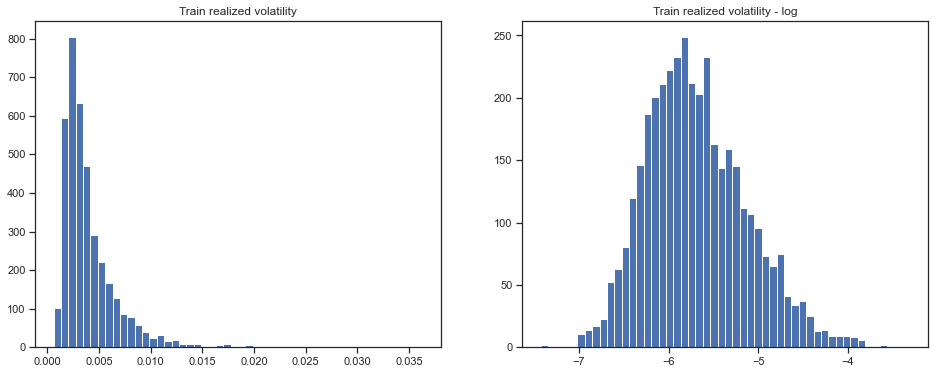

In [21]:
vol_stock0 = vol_train[vol_train['stock_id'] == 0]

sns.set_theme(style="ticks")
fig = plt.figure(figsize=(16, 6))
# fig.suptitle('Images after equalization preprocessing', fontsize=16)
# fig.tight_layout()

plt.subplot(1, 2, 1)
plt.title("Train realized volatility")
plt.hist(vol_stock0['target'], bins=50)

plt.subplot(1, 2, 2)
plt.title("Train realized volatility - log")
plt.hist(np.log(vol_stock0['target']), bins=50)

plt.show()

# Naive RMSE

A commonly known fact about volatility is that it tends to be autocorrelated. We can use this property to implement a naive model that just "predicts" realized volatility by using whatever the realized volatility was in the initial 10 minutes.

Let's calculate the past realized volatility across the training set to see how predictive a single naive signal can be.

In [22]:
# select all stocks books
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '/*')
list_order_book_file_train[:2] # example

['./data/book_train.parquet\\stock_id=0',
 './data/book_train.parquet\\stock_id=1']

In [23]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    '''load datas of one stock_id then calculate WAP, log_return
    set a new DF and put inside realized_volatility per time_id
    add a column with competition form : {stock_id}-{time_id} called row_id

    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0
    prediction_column_name : name of the realized_volatility column
    
    return row_id, prediction_name columns'''
    df_book_data = pd.read_parquet(file_path)
    add_wap(df_book_data)

    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap1'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [24]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

# test on all 126 stocks 
# long ! 230 sec
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')
df_past_realized_train.head()

,row_id,pred
0,0-5,0.004499
1,0-11,0.001204
2,0-16,0.002369
3,0-31,0.002574
4,0-62,0.001894


In [26]:
df_naive = vol_train.copy()
# Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.
# naive prediction = predict same volatility in the next 10min window (auto realisation)
df_naive['row_id'] = df_naive['stock_id'].astype(str) + '-' + df_naive['time_id'].astype(str)
df_naive = df_naive[['row_id','target']]
df_naive = df_naive.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

In [27]:
df_naive.head()

,row_id,target,pred
0,0-5,0.004136,0.004499
1,0-11,0.001445,0.001204
2,0-16,0.002168,0.002369
3,0-31,0.002195,0.002574
4,0-62,0.001747,0.001894


In [28]:
R2 = round(r2_score(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
RMSPE = round(rmspe(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


# Preprocessing

## Improvements

add MAD var, std ?
exponential moving average : pandas.Series.ewm()

instead of dic, more explicit, list to pass to agg  
max_height=pd.NamedAgg(column='height', aggfunc='max'),  
min_weight=pd.NamedAgg(column='weight', aggfunc='min')

fill empty second_in_bucket in book data with the same as the last one
fill                            trade with 0 ?

## Feature engineering

In [29]:
number_of_stocks = 150

### Book train

In [30]:
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '*')[:number_of_stocks]

In [31]:
def add_ponderate_wap(df, col_name='wap_p'):
        df[col_name] = ((
        df['wap1'] * (df['ask_size1'] + df['bid_size1']) +
        df['wap2'] * (df['ask_size2'] + df['bid_size2'])) /
        (df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']))

def add_log_return(df, price_col, log_col_name, group='time_id'):
        df[log_col_name] = df.groupby([group])[price_col].apply(log_return)


def add_balance_to_mean(df, price, bal_col_nam, group='time_id'):
        df[bal_col_nam] = book_train[price] - book_train.groupby([group])[price].transform('mean')



In [32]:
def book_feature_eng_per_stock(file_path):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0

    return the df '''
    book_train = pd.read_parquet(file_path)

    add_wap(book_train, 1, column_prefix='wap')
    add_wap(book_train, 2, column_prefix='wap')
    add_ponderate_wap(book_train, col_name='wap_p')

    add_log_return(book_train, 'wap1', 'log_return')
    add_log_return(book_train, 'wap_p', 'log_return_p')

    book_train = book_train[~(book_train['log_return'].isnull() | book_train['log_return_p'].isnull())] # at the end ?

    
    return book_train

In [33]:
# sample with stock 0
book_feature_eng_per_stock(list_order_book_file_train[0]).head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap1,wap2,wap_p,log_return,log_return_p
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,1.001390,1.001419,0.000014,-1.250457e-06
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,1.001391,1.001419,0.000000,5.040343e-07
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,1.001391,1.001420,-0.000005,3.130015e-07
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,1.001391,1.001420,0.000000,0.000000e+00
5,5,11,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,1.001391,1.001419,0.000005,-3.130015e-07


In [34]:
# feature_dict = {
# 'log_return':[realized_volatility],
# 'log_return_p':[realized_volatility],
# 'wap1':[np.mean],
# 'wap2':[np.mean],
# 'wap_p':[np.mean, np.var, pd.Series.mad]
#         }

# feature_agg = (
#         realized_vol_log_return=('log_return', realized_volatility),
#         realized_vol_log_return_p=('log_return_p', realized_volatility),
#         wap1_mean=('wap1', np.mean),
#         wap2_mean=('wap2', np.mean),
#         wap_p_mean=('wap_p', np.mean),
#         wap_p_var=('wap_p', np.var),
#         wap_p_mad=('wap_p', pd.Series.mad),
# )


In [35]:
# def book_aggregate_form(list_file,dic):

#     df_agg = pd.DataFrame()
#     for file in list_file:
#         df_agg_stock, stock_id = book_feature_eng_per_stock(file)
#         df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(dic)).reset_index()

#         df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
        
#         df_agg = pd.concat([df_agg, df_agg_stock])

#     return df_agg

# depreciated with parallele function
def book_agg_form(list_file):
    ''' Create a new df that aggregate data by time_id
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    df_agg = pd.DataFrame()
    for file in list_file:
        stock_id = file.split('=')[1]
        df_agg_stock = book_feature_eng_per_stock(file)
        df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(
                    bk_realized_vol_log_return=('log_return', realized_volatility),
                    bk_realized_vol_log_return_p=('log_return_p', realized_volatility),
                    wap1_mean=('wap1', np.mean),
                    wap2_mean=('wap2', np.mean),
                    wap_p_mean=('wap_p', np.mean),
                    wap_p_var=('wap_p', np.var),
                    wap_p_mad=('wap_p', pd.Series.mad),
                    )).reset_index()

        df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
        # df_agg_stock['stock_id'] = stock_id
        df_agg_stock.drop('time_id', axis=1, inplace=True)
        
        df_agg = pd.concat([df_agg, df_agg_stock])

    return df_agg

def book_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = book_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(
                bk_realized_vol_log_return=('log_return', realized_volatility),
                bk_realized_vol_log_return_p=('log_return_p', realized_volatility),
                wap1_mean=('wap1', np.mean),
                wap2_mean=('wap2', np.mean),
                wap_p_mean=('wap_p', np.mean),
                wap_p_var=('wap_p', np.var),
                wap_p_mad=('wap_p', pd.Series.mad),
                )).reset_index()

    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock

In [36]:
# %%time
# # df_book_agg = book_aggregate_form(list_order_book_file_train, feature_dict)
# df_book_agg = book_agg_form(list_order_book_file_train)

# df_book_agg.head()

In [37]:
from joblib import Parallel, delayed

In [38]:
def agg_df_and_concatenate_parallel(paths_list, func):

    df_agg = Parallel(n_jobs=-1)(
        delayed(func)(file) 
        for file in paths_list
    )
    
    df_agg = pd.concat(df_agg, ignore_index = True)

    return df_agg

In [39]:
%%time
df_book_agg = agg_df_and_concatenate_parallel(list_order_book_file_train, book_agg_form_parallele)
df_book_agg.head()

Wall time: 2min


,bk_realized_vol_log_return,bk_realized_vol_log_return_p,wap1_mean,wap2_mean,wap_p_mean,wap_p_var,wap_p_mad,row_id
0,0.004499,0.004106,1.003733,1.003668,1.003735,4.938360e-07,0.000472,0-5
1,0.001204,0.001507,1.000240,1.000208,1.000238,5.125136e-08,0.000171,0-11
2,0.002369,0.002469,0.999541,0.999682,0.999603,7.228531e-07,0.000674,0-16
3,0.002574,0.002709,0.998819,0.998624,0.998732,4.741041e-07,0.000520,0-31
4,0.001894,0.001932,0.999616,0.999624,0.999654,6.201692e-08,0.000210,0-62


### Trades

In [40]:
list_order_trade_file_train = glob.glob(data_folder + td_train_fol + '*')[:number_of_stocks]
stock_id_max = int(list_order_trade_file_train[-1].split('=')[1])

In [41]:
def add_ponderate_wap(df, col_name='wap_p'):
        df[col_name] = ((
        df['wap1'] * (df['ask_size1'] + df['bid_size1']) +
        df['wap2'] * (df['ask_size2'] + df['bid_size2'])) /
        (df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']))

def add_log_return(df, price_col, log_col_name, group='time_id'):
        df[log_col_name] = df.groupby([group])[price_col].apply(log_return)


def add_balance_to_mean(df, price, bal_col_nam, group='time_id'):
        df[bal_col_nam] = book_train[price] - book_train.groupby([group])[price].transform('mean')



In [42]:
def trade_feature_eng_per_stock(file_path):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/trade_train/stock_id=0

    return the df '''
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']

    df = df[~df['log_return'].isnull()] # at the end ?
    return df

In [43]:
# sample with stock 0
trade_feature_eng_per_stock(list_order_trade_file_train[0]).head()

,time_id,seconds_in_bucket,price,size,order_count,log_return,amount
1,5,46,1.002778,128,4,0.000476,128.355591
2,5,50,1.002818,55,1,0.000040,55.155016
3,5,57,1.003155,121,5,0.000336,121.381797
4,5,68,1.003646,4,1,0.000489,4.014584
5,5,78,1.003762,134,5,0.000116,134.504173


In [44]:
# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

In [45]:
def trade_agg_form(list_file):
    ''' Create a new df that aggregate data by time_id
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    df_agg = pd.DataFrame()
    for file in list_file:
        stock_id = file.split('=')[1]
        df_agg_stock = trade_feature_eng_per_stock(file)
        df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(
                    td_realized_vol_log_return=('log_return', realized_volatility),
                    td_number=('seconds_in_bucket', count_unique),
                    td_size_sum=('size', np.sum),
                    td_size_mean=('size', np.mean),
                    td_order_mean=('order_count', np.mean),
                    td_amount_sum=('amount', np.sum),
                    td_amount_mean=('amount', np.mean)
                    )).reset_index()
        

        df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
        # df_agg_stock['stock_id'] = stock_id
        df_agg_stock.drop('time_id', axis=1, inplace=True)
        
        df_agg = pd.concat([df_agg, df_agg_stock])

    return df_agg

def trade_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = trade_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(
                td_realized_vol_log_return=('log_return', realized_volatility),
                td_number=('seconds_in_bucket', count_unique),
                td_size_sum=('size', np.sum),
                td_size_mean=('size', np.mean),
                td_order_mean=('order_count', np.mean),
                td_amount_sum=('amount', np.sum),
                td_amount_mean=('amount', np.mean)
                )).reset_index()
    

    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock

In [46]:
# %%time
# df_trade_agg = trade_agg_form(list_order_trade_file_train)
# df_trade_agg.head()

In [47]:
%%time
df_trade_agg = agg_df_and_concatenate_parallel(list_order_trade_file_train, trade_agg_form_parallele)
df_trade_agg.head()

Wall time: 36.9 s


,td_realized_vol_log_return,td_number,td_size_sum,td_size_mean,td_order_mean,td_amount_sum,td_amount_mean,row_id
0,0.002006,39,2853,73.153846,2.512821,2863.388946,73.420229,0-5
1,0.000901,29,1287,44.379310,1.896552,1287.353784,44.391510,0-11
2,0.001961,24,2159,89.958333,2.791667,2156.608498,89.858687,0-16
3,0.001561,14,1949,139.214286,4.142857,1946.602539,139.043038,0-31
4,0.000871,21,1790,85.238095,4.190476,1789.254472,85.202594,0-62


### Joining

In [48]:
df = vol_train[vol_train.stock_id <= stock_id_max].copy()
df['row_id'] = df['stock_id'].astype(str) + '-' + df['time_id'].astype(str)

df = df.merge(df_book_agg, on = ['row_id'], how = 'left')
df = df.merge(df_trade_agg, on = ['row_id'], how = 'left')

df.head()

,stock_id,time_id,target,row_id,bk_realized_vol_log_return,bk_realized_vol_log_return_p,wap1_mean,wap2_mean,wap_p_mean,wap_p_var,wap_p_mad,td_realized_vol_log_return,td_number,td_size_sum,td_size_mean,td_order_mean,td_amount_sum,td_amount_mean
0,0,5,0.004136,0-5,0.004499,0.004106,1.003733,1.003668,1.003735,4.938360e-07,0.000472,0.002006,39.0,2853.0,73.153846,2.512821,2863.388946,73.420229
1,0,11,0.001445,0-11,0.001204,0.001507,1.000240,1.000208,1.000238,5.125136e-08,0.000171,0.000901,29.0,1287.0,44.379310,1.896552,1287.353784,44.391510
2,0,16,0.002168,0-16,0.002369,0.002469,0.999541,0.999682,0.999603,7.228531e-07,0.000674,0.001961,24.0,2159.0,89.958333,2.791667,2156.608498,89.858687
3,0,31,0.002195,0-31,0.002574,0.002709,0.998819,0.998624,0.998732,4.741041e-07,0.000520,0.001561,14.0,1949.0,139.214286,4.142857,1946.602539,139.043038
4,0,62,0.001747,0-62,0.001894,0.001932,0.999616,0.999624,0.999654,6.201692e-08,0.000210,0.000871,21.0,1790.0,85.238095,4.190476,1789.254472,85.202594


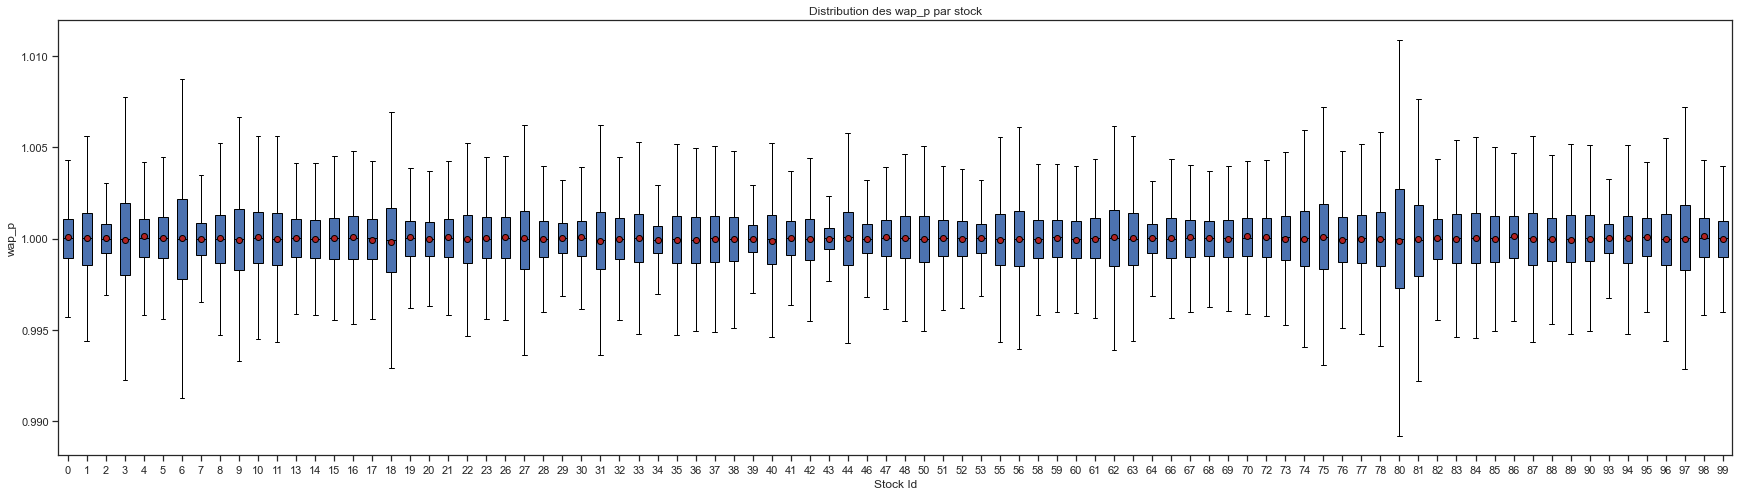

In [49]:
#Création d'un sous échantillon par modalité
groupes = []
for s in df['stock_id'].unique():
    groupes.append(df[df['stock_id'] == s]['wap_p_mean'])
 
# 'OO' méthode pour plot
fig, ax = plt.subplots(figsize=(30,8))

# Propriétés graphiques
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

ax.boxplot(groupes,
           labels=df['stock_id'].unique(),
           showfliers=False,
           medianprops=medianprops, 
           vert=True,
           patch_artist=True,
           showmeans=True,
           meanprops=meanprops)

ax.set(title='Distribution des wap_p par stock',
      xlabel="Stock Id",
      ylabel='wap_p')

plt.show()

In [50]:
df.to_pickle(output + 'dataset_train.pkl')

# machine learning

In [51]:
df = pd.read_pickle(output + 'dataset_train.pkl')

In [52]:
df.head()

,stock_id,time_id,target,row_id,bk_realized_vol_log_return,bk_realized_vol_log_return_p,wap1_mean,wap2_mean,wap_p_mean,wap_p_var,wap_p_mad,td_realized_vol_log_return,td_number,td_size_sum,td_size_mean,td_order_mean,td_amount_sum,td_amount_mean
0,0,5,0.004136,0-5,0.004499,0.004106,1.003733,1.003668,1.003735,4.938360e-07,0.000472,0.002006,39.0,2853.0,73.153846,2.512821,2863.388946,73.420229
1,0,11,0.001445,0-11,0.001204,0.001507,1.000240,1.000208,1.000238,5.125136e-08,0.000171,0.000901,29.0,1287.0,44.379310,1.896552,1287.353784,44.391510
2,0,16,0.002168,0-16,0.002369,0.002469,0.999541,0.999682,0.999603,7.228531e-07,0.000674,0.001961,24.0,2159.0,89.958333,2.791667,2156.608498,89.858687
3,0,31,0.002195,0-31,0.002574,0.002709,0.998819,0.998624,0.998732,4.741041e-07,0.000520,0.001561,14.0,1949.0,139.214286,4.142857,1946.602539,139.043038
4,0,62,0.001747,0-62,0.001894,0.001932,0.999616,0.999624,0.999654,6.201692e-08,0.000210,0.000871,21.0,1790.0,85.238095,4.190476,1789.254472,85.202594


In [53]:
df.isnull().sum()

stock_id                         0
time_id                          0
target                           0
row_id                           0
bk_realized_vol_log_return       0
bk_realized_vol_log_return_p     0
wap1_mean                        0
wap2_mean                        0
wap_p_mean                       0
wap_p_var                        0
wap_p_mad                        0
td_realized_vol_log_return      74
td_number                       74
td_size_sum                     74
td_size_mean                    74
td_order_mean                   74
td_amount_sum                   74
td_amount_mean                  74
dtype: int64

In [54]:
df.fillna(0, inplace=True)
df.isnull().sum().sum()

0

## KNN regression

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline



In [56]:
pip_knn = make_pipeline(StandardScaler(),
                          KNeighborsRegressor())

NameError: name 'StandardScaler' is not defined

## LSTM Regression (1.ipynb)

In [57]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold

In [58]:
X = df.drop(['row_id','target'],axis=1)
y = df['target']

kf = KFold(n_splits=25, random_state=42, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0   


# Feature Engineering + Tuned XGBoost & LGBM NB

In [59]:

def plot_feature_importance(df, model):
    feature_importances_df = pd.DataFrame({
        'feature': df.columns,
        'importance_score': model.feature_importances_
    })
    fig = plt.figure(figsize=(20, 5))
    ax = sns.barplot(x = "feature", y = "importance_score", data = feature_importances_df)
    ax.set(xlabel="Features", ylabel = "Importance Score")
    # plt.xticks(ha='left', rotation=45)
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    plt.show()
    # return feature_importances_df

In [60]:
X = df.drop(['row_id', 'target'], axis = 1)
X_val = X.values
y = df['target']
y_val = y.values

X.shape, y.shape

((337013, 16), (337013,))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((286461, 16), (50552, 16), (286461,), (50552,))

## Basic XGB model

In [62]:
X

,stock_id,time_id,bk_realized_vol_log_return,bk_realized_vol_log_return_p,wap1_mean,wap2_mean,wap_p_mean,wap_p_var,wap_p_mad,td_realized_vol_log_return,td_number,td_size_sum,td_size_mean,td_order_mean,td_amount_sum,td_amount_mean
0,0,5,0.004499,0.004106,1.003733,1.003668,1.003735,4.938360e-07,0.000472,0.002006,39.0,2853.0,73.153846,2.512821,2863.388946,73.420229
1,0,11,0.001204,0.001507,1.000240,1.000208,1.000238,5.125136e-08,0.000171,0.000901,29.0,1287.0,44.379310,1.896552,1287.353784,44.391510
2,0,16,0.002369,0.002469,0.999541,0.999682,0.999603,7.228531e-07,0.000674,0.001961,24.0,2159.0,89.958333,2.791667,2156.608498,89.858687
3,0,31,0.002574,0.002709,0.998819,0.998624,0.998732,4.741041e-07,0.000520,0.001561,14.0,1949.0,139.214286,4.142857,1946.602539,139.043038
4,0,62,0.001894,0.001932,0.999616,0.999624,0.999654,6.201692e-08,0.000210,0.000871,21.0,1790.0,85.238095,4.190476,1789.254472,85.202594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337008,99,32751,0.001436,0.001581,1.000643,1.000638,1.000642,2.196048e-07,0.000399,0.001138,102.0,47753.0,468.166667,4.794118,47784.512244,468.475610
337009,99,32753,0.001795,0.001811,1.000510,1.000496,1.000497,4.432406e-07,0.000560,0.001527,91.0,48625.0,534.340659,6.417582,48654.367399,534.663378
337010,99,32758,0.001658,0.001670,0.998347,0.998355,0.998355,4.060871e-07,0.000522,0.001403,83.0,50338.0,606.481928,5.493976,50244.794024,605.358964
337011,99,32763,0.002213,0.002272,0.998895,0.998911,0.998893,9.017561e-08,0.000225,0.001778,165.0,46919.0,284.357576,3.545455,46869.310801,284.056429


In [63]:
if env == 'kaggle':
    xgb = XGBRegressor(tree_method='gpu_hist', random_state=42, n_jobs= - 1)
else:
    xgb = XGBRegressor(tree_method='hist', random_state=42, n_jobs= - 1)



In [64]:
%%time
xgb.fit(X_train, y_train)

Wall time: 1.9 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [65]:
xgb_preds = xgb.predict(X_test)
R2 = round(r2_score(y_true = y_test, y_pred = xgb_preds), 6)
RMSPE = round(rmspe(y_true = y_test, y_pred = xgb_preds), 6)
print(f'Performance of the XGBOOST prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the XGBOOST prediction: R2 score: 0.765936, RMSPE: 0.2712


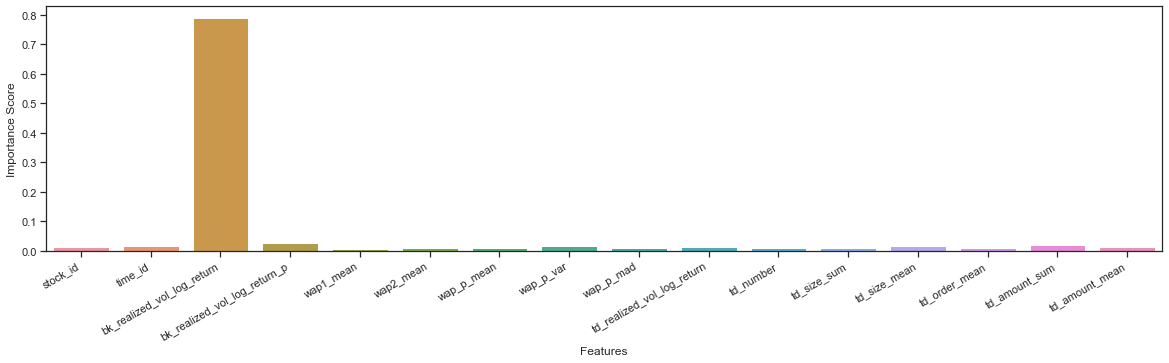

In [66]:
plot_feature_importance(X, xgb)

## Basic LGBMRegressor model

In [67]:
if env == 'kaggle':
    lgbm = LGBMRegressor(device='gpu', random_state=42)
else:
    lgbm = LGBMRegressor(device='cpu', random_state=42)


In [68]:
%%time
lgbm.fit(X_train, y_train)

Wall time: 1.07 s


LGBMRegressor(device='cpu', random_state=42)

In [69]:
lgbm_preds = lgbm.predict(X_test)
R2 = round(r2_score(y_true = y_test, y_pred = lgbm_preds),6)
RMSPE = round(rmspe(y_true = y_test, y_pred = lgbm_preds),6)
print(f'Performance of the LIGHTGBM prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the LIGHTGBM prediction: R2 score: 0.788022, RMSPE: 0.28317


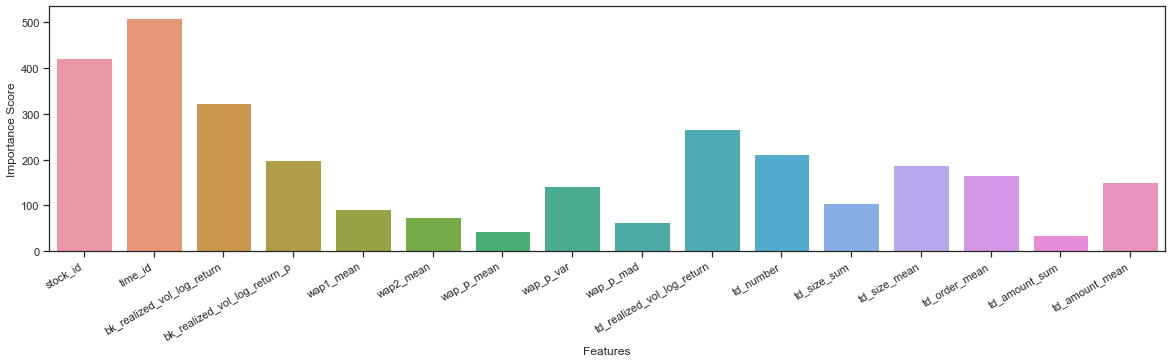

In [70]:
plot_feature_importance(X, lgbm)

## Optuna Tuned XGBoost

Optuna va nous permettre de trouver nos meilleurs hyperparamètres.  
Il suffira ensuite d'entraîner notre modèle avec ces paramètres pour l'évaluer.

In [71]:
import optuna

In [78]:
n_trials = 50

In [77]:
def objective_xgb(trial):
    
    if env == 'kaggle':
        param = {
            'tree_method':'gpu_hist', 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
            'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)}
    else:
        param = {
            'tree_method':'hist', 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
            'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)}
    
    model = XGBRegressor(**param)
    
    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    model.fit(X_train ,y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(X_test)
    
    return rmspe(y_test, preds)

In [79]:
%%time
study_xgb = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_xgb.optimize(objective_xgb, n_trials=n_trials, gc_after_trial=True)

[I 2021-09-16 07:43:50,517] A new study created in memory with name: no-name-56221800-3f5d-4b5d-8529-382d6ad94d56
[I 2021-09-16 07:44:07,625] Trial 0 finished with value: 0.2876341876000313 and parameters: {'lambda': 0.6270189540271124, 'alpha': 0.024353660541527808, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.02, 'n_estimators': 1392, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 297}. Best is trial 0 with value: 0.2876341876000313.
[I 2021-09-16 07:44:47,990] Trial 1 finished with value: 0.2847740556518567 and parameters: {'lambda': 0.011465574915208592, 'alpha': 0.06305303560981472, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 2469, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 108}. Best is trial 1 with value: 0.2847740556518567.
[I 2021-09-16 07:45:14,340] Trial 2 finished with value: 0.28457803730800957 and parameters: {'lambda': 0.014167626148091198, 'alpha': 0.16650486036378503, 'colsample_bytree': 0.

Wall time: 21min 15s


In [80]:
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

Number of finished trials: 50
Best trial: {'lambda': 1.0795339603195273, 'alpha': 0.028923117320982822, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 1927, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 277}


In [81]:
optuna.visualization.plot_optimization_history(study_xgb)

In [82]:
optuna.visualization.plot_param_importances(study_xgb)

In [83]:
best_xgbparams = study_xgb.best_params
best_xgbparams

{'lambda': 1.0795339603195273,
 'alpha': 0.028923117320982822,
 'colsample_bytree': 0.3,
 'subsample': 0.7,
 'learning_rate': 0.014,
 'n_estimators': 1927,
 'max_depth': 15,
 'random_state': 48,
 'min_child_weight': 277}

In [84]:
if env == 'Kaggle':
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='gpu_hist')
else:
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='hist', n_jobs= - 1)

In [85]:
%%time
xgb_opt.fit(X_train ,y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

preds = xgb_opt.predict(X_test)
R2 = round(r2_score(y_true = y_test, y_pred = preds), 5)
RMSPE = round(rmspe(y_true = y_test, y_pred = preds), 5)
print(f'Performance of the Tuned XGB prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the Tuned XGB prediction: R2 score: 0.79372, RMSPE: 0.27725
Wall time: 30.2 s


## About Kfold

In [86]:
RANDOM_SEED = 42

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params
##################
# Ridge
##################
def ridge_objective(trial):
    _alpha = trial.suggest_float("alpha", 0.1, 20)
    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)
    scores = cross_val_score(
        ridge, X, y, cv=kfolds,
        scoring="neg_root_mean_squared_error"
    )
    return scores.mean()

ridge_params = tune(ridge_objective)
# After tuning it for once, we can copy the best params to create the model without tunning it again
# ridge_params = {'alpha': 7.491061624529043}
ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)

[I 2021-09-16 08:34:22,328] A new study created in memory with name: no-name-e221ef38-1952-4ac0-95ea-7f4d7595001f
[W 2021-09-16 08:34:22,332] Trial 0 failed because of the following error: NameError("name 'Ridge' is not defined")
Traceback (most recent call last):
  File "C:\Users\Admin\miniconda3\envs\env_p8\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Admin\AppData\Local\Temp/ipykernel_22196/1214677984.py", line 20, in ridge_objective
    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)
NameError: name 'Ridge' is not defined


NameError: name 'Ridge' is not defined

## Optuna Tuned LGBM

In [87]:
def objective_lgbm(trial):
    
    if env == 'kaggle':
        param = {
            "device": "gpu",
            "metric": "rmse",
            "verbosity": -1,
            'learning_rate':trial.suggest_loguniform('learning_rate', 0.005, 0.5),
            "max_depth": trial.suggest_int("max_depth", 2, 500),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "n_estimators": trial.suggest_int("n_estimators", 100, 4000),
    #         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100000, 700000),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}
    else:
        param = {
            "device": "cpu",
            "metric": "rmse",
            "verbosity": -1,
            'learning_rate':trial.suggest_loguniform('learning_rate', 0.005, 0.5),
            "max_depth": trial.suggest_int("max_depth", 2, 500),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "n_estimators": trial.suggest_int("n_estimators", 100, 4000),
    #         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100000, 700000),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

    preds = model.predict(X_test)
    return rmspe(y_test, preds)

In [88]:
%%time
study_lgbm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_lgbm.optimize(objective_lgbm, n_trials=n_trials, gc_after_trial=True)

[I 2021-09-16 10:00:46,374] A new study created in memory with name: no-name-37496e26-1615-4897-8881-2937a4d01687


[LightGBM] [Warning] feature_fraction is set=0.7248722612366483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7248722612366483
[LightGBM] [Warning] lambda_l1 is set=2.5046465192567768e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5046465192567768e-06
[LightGBM] [Warning] bagging_fraction is set=0.49823525892636455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49823525892636455
[LightGBM] [Warning] lambda_l2 is set=0.006532375823678051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006532375823678051
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-09-16 10:00:50,633] Trial 0 finished with value: 0.28144190331483343 and parameters: {'learning_rate': 0.11319236868616477, 'max_depth': 123, 'lambda_l1': 2.5046465192567768e-06, 'lambda_l2': 0.006532375823678051, 'num_leaves': 151, 'n_estimators': 303, 'feature_fraction': 0.7248722612366483, 'bagging_fraction': 0.49823525892636455, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.9143388746777631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9143388746777631
[LightGBM] [Warning] lambda_l1 is set=0.0014057164633944912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014057164633944912
[LightGBM] [Warning] bagging_fraction is set=0.9146946990554271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9146946990554271
[LightGBM] [Warning] lambda_l2 is set=0.0005559623324553599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005559623324553599
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-09-16 10:00:53,450] Trial 1 finished with value: 0.2870364383472287 and parameters: {'learning_rate': 0.37492521485825436, 'max_depth': 278, 'lambda_l1': 0.0014057164633944912, 'lambda_l2': 0.0005559623324553599, 'num_leaves': 137, 'n_estimators': 3975, 'feature_fraction': 0.9143388746777631, 'bagging_fraction': 0.9146946990554271, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.4488681196050936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4488681196050936
[LightGBM] [Warning] lambda_l1 is set=0.08601245346902094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08601245346902094
[LightGBM] [Warning] bagging_fraction is set=0.5232974567254349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5232974567254349
[LightGBM] [Warning] lambda_l2 is set=0.00047535369658062237, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047535369658062237
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-09-16 10:00:59,346] Trial 2 finished with value: 0.29325369224316095 and parameters: {'learning_rate': 0.06827357610592759, 'max_depth': 397, 'lambda_l1': 0.08601245346902094, 'lambda_l2': 0.00047535369658062237, 'num_leaves': 151, 'n_estimators': 288, 'feature_fraction': 0.4488681196050936, 'bagging_fraction': 0.5232974567254349, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.5661209329386363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5661209329386363
[LightGBM] [Warning] lambda_l1 is set=4.280926316254671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.280926316254671
[LightGBM] [Warning] bagging_fraction is set=0.42326994113815763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42326994113815763
[LightGBM] [Warning] lambda_l2 is set=0.002003792272170443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002003792272170443
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-09-16 10:01:14,946] Trial 3 finished with value: 0.33869564664151075 and parameters: {'learning_rate': 0.008238985833362295, 'max_depth': 306, 'lambda_l1': 4.280926316254671, 'lambda_l2': 0.002003792272170443, 'num_leaves': 127, 'n_estimators': 3341, 'feature_fraction': 0.5661209329386363, 'bagging_fraction': 0.42326994113815763, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.8435700292469661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8435700292469661
[LightGBM] [Warning] lambda_l1 is set=0.9108548751724227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9108548751724227
[LightGBM] [Warning] bagging_fraction is set=0.41273942499342914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41273942499342914
[LightGBM] [Warning] lambda_l2 is set=0.00010966761746041805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010966761746041805
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-09-16 10:01:17,033] Trial 4 finished with value: 0.309070417165266 and parameters: {'learning_rate': 0.08331101827154604, 'max_depth': 38, 'lambda_l1': 0.9108548751724227, 'lambda_l2': 0.00010966761746041805, 'num_leaves': 219, 'n_estimators': 1815, 'feature_fraction': 0.8435700292469661, 'bagging_fraction': 0.41273942499342914, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.4461186912667152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4461186912667152
[LightGBM] [Warning] lambda_l1 is set=1.5620134578651117e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5620134578651117e-08
[LightGBM] [Warning] bagging_fraction is set=0.9733069310155901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733069310155901
[LightGBM] [Warning] lambda_l2 is set=1.1258931489757172e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1258931489757172e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-09-16 10:01:20,433] Trial 5 finished with value: 0.28653115924326183 and parameters: {'learning_rate': 0.40932030082751947, 'max_depth': 91, 'lambda_l1': 1.5620134578651117e-08, 'lambda_l2': 1.1258931489757172e-05, 'num_leaves': 239, 'n_estimators': 3137, 'feature_fraction': 0.4461186912667152, 'bagging_fraction': 0.9733069310155901, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.44579673078353843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44579673078353843
[LightGBM] [Warning] lambda_l1 is set=7.235239293793475e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235239293793475e-07
[LightGBM] [Warning] bagging_fraction is set=0.4026433636795553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4026433636795553
[LightGBM] [Warning] lambda_l2 is set=0.0002457103993491276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002457103993491276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-09-16 10:01:22,247] Trial 6 finished with value: 0.28202043634010926 and parameters: {'learning_rate': 0.278472507331696, 'max_depth': 166, 'lambda_l1': 7.235239293793475e-07, 'lambda_l2': 0.0002457103993491276, 'num_leaves': 73, 'n_estimators': 1542, 'feature_fraction': 0.44579673078353843, 'bagging_fraction': 0.4026433636795553, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.5660784791909003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5660784791909003
[LightGBM] [Warning] lambda_l1 is set=2.899941436691298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.899941436691298
[LightGBM] [Warning] bagging_fraction is set=0.9085156022311982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9085156022311982
[LightGBM] [Warning] lambda_l2 is set=0.0016243818450202975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016243818450202975
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-09-16 10:01:22,756] Trial 7 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:23,308] Trial 8 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:23,874] Trial 9 pruned. Trial was pruned at iteration 14.
[I 2021-09-16 10:01:24,395] Trial 10 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:27,329] Trial 11 finished with value: 0.2833771442955806 and parameters: {'learning_rate': 0.1953763561330758, 'max_depth': 163, 'lambda_l1': 2.5995919067125776e-07, 'lambda_l2': 1.1448650989859572, 'num_leaves': 62, 'n_estimators': 1235, 'feature_fraction': 0.5893466110546811, 'bagging_fraction': 0.5963229877744239, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.6560408414638133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6560408414638133
[LightGBM] [Warning] lambda_l1 is set=1.3322182831457952e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3322182831457952e-06
[LightGBM] [Warning] bagging_fraction is set=0.7593471483171559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593471483171559
[LightGBM] [Warning] lambda_l2 is set=0.0982909972280546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0982909972280546
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-09-16 10:01:27,923] Trial 12 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:28,735] Trial 13 pruned. Trial was pruned at iteration 19.
[I 2021-09-16 10:01:31,072] Trial 14 finished with value: 0.2836272037219396 and parameters: {'learning_rate': 0.15498629919928034, 'max_depth': 102, 'lambda_l1': 2.177766665288069e-08, 'lambda_l2': 1.1704597133912548e-06, 'num_leaves': 86, 'n_estimators': 2262, 'feature_fraction': 0.767998578483125, 'bagging_fraction': 0.733286040575857, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.4003242077897168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4003242077897168
[LightGBM] [Warning] lambda_l1 is set=1.5363027868824725e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5363027868824725e-05
[LightGBM] [Warning] bagging_fraction is set=0.5000125745853566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5000125745853566
[LightGBM] [Warning] lambda_l2 is set=0.010468788976367969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010468788976367969
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-09-16 10:01:31,573] Trial 15 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:33,749] Trial 16 finished with value: 0.28778878862181273 and parameters: {'learning_rate': 0.2618237194726345, 'max_depth': 342, 'lambda_l1': 1.8878237185970474e-07, 'lambda_l2': 5.4340899904665925, 'num_leaves': 106, 'n_estimators': 1588, 'feature_fraction': 0.613689373608827, 'bagging_fraction': 0.6466650918749877, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.5118993870318831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118993870318831
[LightGBM] [Warning] lambda_l1 is set=0.002750089861236458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002750089861236458
[LightGBM] [Warning] bagging_fraction is set=0.5023294651026824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5023294651026824
[LightGBM] [Warning] lambda_l2 is set=1.4215365666875847e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4215365666875847e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-09-16 10:01:34,458] Trial 17 pruned. Trial was pruned at iteration 15.
[I 2021-09-16 10:01:35,012] Trial 18 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:35,566] Trial 19 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:36,127] Trial 20 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:37,546] Trial 21 finished with value: 0.29068967567272597 and parameters: {'learning_rate': 0.2487764358799566, 'max_depth': 181, 'lambda_l1': 1.617182709147098e-07, 'lambda_l2': 2.7879574029109384, 'num_leaves': 46, 'n_estimators': 1234, 'feature_fraction': 0.5305047363522305, 'bagging_fraction': 0.5914049034484142, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.6196117765449306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6196117765449306
[LightGBM] [Warning] lambda_l1 is set=6.147803888792899e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.147803888792899e-07
[LightGBM] [Warning] bagging_fraction is set=0.6564888250227467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6564888250227467
[LightGBM] [Warning] lambda_l2 is set=0.6224799643755786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6224799643755786
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-09-16 10:01:38,162] Trial 22 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:38,782] Trial 23 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:39,671] Trial 24 pruned. Trial was pruned at iteration 18.
[I 2021-09-16 10:01:40,198] Trial 25 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:40,743] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:41,328] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:41,959] Trial 28 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:43,797] Trial 29 finished with value: 0.28876527232748034 and parameters: {'learning_rate': 0.3361637673777107, 'max_depth': 295, 'lambda_l1': 0.0028424017036363966, 'lambda_l2': 0.0012395416965236541, 'num_leaves': 90, 'n_estimators': 100, 'feature_fraction': 0.5436860067298542, 'bagging_fraction': 0.4585530300917118, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.9292471825719193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9292471825719193
[LightGBM] [Warning] lambda_l1 is set=0.0008343246841704629, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008343246841704629
[LightGBM] [Warning] bagging_fraction is set=0.546912944897495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.546912944897495
[LightGBM] [Warning] lambda_l2 is set=0.0001613394943671142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001613394943671142
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-09-16 10:01:44,290] Trial 30 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:44,843] Trial 31 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:45,466] Trial 32 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:46,039] Trial 33 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:48,015] Trial 34 finished with value: 0.2850897062617701 and parameters: {'learning_rate': 0.36062639816715936, 'max_depth': 47, 'lambda_l1': 0.012671820631059361, 'lambda_l2': 4.555698340111506e-05, 'num_leaves': 59, 'n_estimators': 1716, 'feature_fraction': 0.7888662820005206, 'bagging_fraction': 0.713204431939527, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: 0.28144190331483343.


[LightGBM] [Warning] feature_fraction is set=0.672647782452585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.672647782452585
[LightGBM] [Warning] lambda_l1 is set=1.0743078969994812e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0743078969994812e-08
[LightGBM] [Warning] bagging_fraction is set=0.6770545193525819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6770545193525819
[LightGBM] [Warning] lambda_l2 is set=0.0005075421044980622, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005075421044980622
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-09-16 10:01:48,737] Trial 35 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:49,548] Trial 36 pruned. Trial was pruned at iteration 9.
[I 2021-09-16 10:01:50,137] Trial 37 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:50,758] Trial 38 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:51,331] Trial 39 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:51,971] Trial 40 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:01:52,783] Trial 41 pruned. Trial was pruned at iteration 16.
[I 2021-09-16 10:01:56,195] Trial 42 finished with value: 0.2802352439819433 and parameters: {'learning_rate': 0.3507770208708439, 'max_depth': 37, 'lambda_l1': 0.02552884572641897, 'lambda_l2': 0.0007962687310814223, 'num_leaves': 79, 'n_estimators': 1740, 'feature_fraction': 0.7566213973625975, 'bagging_fraction': 0.7800566771538368, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 42 with value: 0.2802352439819433.


[LightGBM] [Warning] feature_fraction is set=0.7449846562399918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7449846562399918
[LightGBM] [Warning] lambda_l1 is set=0.10132938786741665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10132938786741665
[LightGBM] [Warning] bagging_fraction is set=0.763159156947747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763159156947747
[LightGBM] [Warning] lambda_l2 is set=0.003895505753549161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003895505753549161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-16 10:02:00,068] Trial 43 finished with value: 0.2791494895662542 and parameters: {'learning_rate': 0.3013031223349687, 'max_depth': 69, 'lambda_l1': 0.10132938786741665, 'lambda_l2': 0.003895505753549161, 'num_leaves': 77, 'n_estimators': 2119, 'feature_fraction': 0.7449846562399918, 'bagging_fraction': 0.763159156947747, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 43 with value: 0.2791494895662542.


[LightGBM] [Warning] feature_fraction is set=0.6882002249965787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6882002249965787
[LightGBM] [Warning] lambda_l1 is set=0.3623595046354893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3623595046354893
[LightGBM] [Warning] bagging_fraction is set=0.7860463228325525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860463228325525
[LightGBM] [Warning] lambda_l2 is set=0.0008791588305914528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008791588305914528
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-09-16 10:02:00,847] Trial 44 pruned. Trial was pruned at iteration 7.
[I 2021-09-16 10:02:01,671] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:02:05,013] Trial 46 finished with value: 0.2904740966102643 and parameters: {'learning_rate': 0.4195367684085317, 'max_depth': 149, 'lambda_l1': 0.01088057427195325, 'lambda_l2': 0.03223904518240217, 'num_leaves': 173, 'n_estimators': 346, 'feature_fraction': 0.6979138431403872, 'bagging_fraction': 0.9881022110957436, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 43 with value: 0.2791494895662542.


[LightGBM] [Warning] feature_fraction is set=0.8286807932378333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8286807932378333
[LightGBM] [Warning] lambda_l1 is set=1.0564149973858752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0564149973858752
[LightGBM] [Warning] bagging_fraction is set=0.9382267486120648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9382267486120648
[LightGBM] [Warning] lambda_l2 is set=0.000345774238820487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000345774238820487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-16 10:02:05,543] Trial 47 pruned. Trial was pruned at iteration 8.
[I 2021-09-16 10:02:06,105] Trial 48 pruned. Trial was pruned at iteration 5.
[I 2021-09-16 10:02:06,695] Trial 49 pruned. Trial was pruned at iteration 5.


Wall time: 1min 20s


In [89]:
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)

Number of finished trials: 50
Best trial: {'learning_rate': 0.3013031223349687, 'max_depth': 69, 'lambda_l1': 0.10132938786741665, 'lambda_l2': 0.003895505753549161, 'num_leaves': 77, 'n_estimators': 2119, 'feature_fraction': 0.7449846562399918, 'bagging_fraction': 0.763159156947747, 'bagging_freq': 1, 'min_child_samples': 36}


In [90]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [91]:
optuna.visualization.plot_param_importances(study_lgbm)


In [92]:
best_lgbmparams = study_lgbm.best_params
best_lgbmparams

{'learning_rate': 0.3013031223349687,
 'max_depth': 69,
 'lambda_l1': 0.10132938786741665,
 'lambda_l2': 0.003895505753549161,
 'num_leaves': 77,
 'n_estimators': 2119,
 'feature_fraction': 0.7449846562399918,
 'bagging_fraction': 0.763159156947747,
 'bagging_freq': 1,
 'min_child_samples': 36}

In [93]:
if env == 'Kaggle':
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='gpu')
else:
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='cpu')


In [94]:
%%time
lgbm_opt.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=100)

preds = lgbm_opt.predict(X_test)
R2 = round(r2_score(y_true = y_test, y_pred = preds), 6)
RMSPE = round(rmspe(y_true = y_test, y_pred = preds), 6)
print(f'Performance of the Tuned LIGHTGBM prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the Tuned LIGHTGBM prediction: R2 score: 0.79299, RMSPE: 0.279149
Wall time: 2.26 s


## Stacking Regressor

Stack of estimators with a final regressor.

Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [95]:
if env == 'kaggle':
    xgb = XGBRegressor(tree_method='gpu_hist', random_state = 42, n_jobs= - 1)
    lgbm = LGBMRegressor(device='gpu', random_state=42)
else:
    xgb = XGBRegressor(tree_method='hist', random_state = 42, n_jobs= - 1)
    lgbm = LGBMRegressor(device='cpu', random_state=42)

In [96]:
from sklearn.ensemble import StackingRegressor


estimators = [('xgb', xgb),
              ('lgbm', lgbm),
              ('xgb_opt', xgb_opt)]

# clf = StackingRegressor(estimators=estimators, final_estimator=lgbm, verbose=1, n_jobs=-1)
clf = StackingRegressor(estimators=estimators, verbose=1, n_jobs=-1)

In [97]:
%%time
clf.fit(X_train, y_train)

Wall time: 3min 31s


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=10...
                                            lambda=1.0795339603195273,
                                            learning_rate=0.014,
                       

In [98]:
preds = clf.predict(X_test)
R2 = round(r2_score(y_true = y_test, y_pred = preds),6)
RMSPE = round(rmspe(y_true = y_test, y_pred = preds), 6)
print(f'Performance of the STACK prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the STACK prediction: R2 score: 0.794208, RMSPE: 0.280495


In [101]:
import pickle

In [115]:
model_final = lgbm_opt

In [116]:
filename = 'finalized_model.sav'
pickle.dump(model_final, open(output + filename, 'wb'))

In [117]:
model_final = pickle.load(open(output + filename, 'rb'))

In [118]:
model_final

LGBMRegressor(bagging_fraction=0.763159156947747, bagging_freq=1, device='cpu',
              feature_fraction=0.7449846562399918,
              lambda_l1=0.10132938786741665, lambda_l2=0.003895505753549161,
              learning_rate=0.3013031223349687, max_depth=69,
              min_child_samples=36, n_estimators=2119, num_leaves=77)

# Submission

In [119]:
list_order_book_file_test = glob.glob(data_folder + bk_test_fol + '*')
df_bk_test_agg = agg_df_and_concatenate_parallel(list_order_book_file_test, book_agg_form_parallele)

list_order_trade_file_test = glob.glob(data_folder + td_test_fol + '*')
df_td_test_agg = agg_df_and_concatenate_parallel(list_order_trade_file_test, trade_agg_form_parallele)

df = vol_test.copy()
df['row_id'] = df['stock_id'].astype(str) + '-' + df['time_id'].astype(str)

df = df.merge(df_book_agg, on = ['row_id'], how = 'left')
df = df.merge(df_trade_agg, on = ['row_id'], how = 'left')

X_test = df.drop(['row_id'], axis = 1)
df_pred = df[['row_id']]

df_pred = df_pred.assign(target = model_final.predict(X_test))
df_pred.to_csv('submission.csv',index = False)


In [ ]:
# list_order_book_file_test = glob.glob(data_folder + bk_test_fol + '*')


# df_naive_pred_test = past_realized_volatility_per_stock(list_file=list_order_book_file_test,
#                                                            prediction_column_name='target')
# df_naive_pred_test.to_csv('submission.csv',index = False)

In [124]:
# test_data_set_final = test_data_set.drop(['stock_id', 'time_id'], axis = 1)

# y_pred = test_data_set_final[['row_id']]
# X_test = test_data_set_final.drop(['row_id'], axis = 1)

In [ ]:
# X_test

In [ ]:
# y_pred = y_pred.assign(target = clf.predict(X_test))
# y_pred.to_csv('submission.csv',index = False)

In [127]:
vol_test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [128]:
pd.read_csv('submission.csv')

,row_id,target
0,0-4,0.001858
1,0-32,0.001858
2,0-34,0.001858
